In [1]:
!pip install datasets pillow torch torchvision matplotlib scikit-learn tqdm



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install ipywidgets
from tqdm import tqdm


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
from torchvision import models, transforms
from sklearn.neighbors import NearestNeighbors
from PIL import Image
import os

In [4]:
# Load dataset from Hugging Face
dataset = load_dataset("filnow/furniture-synthetic-dataset")

# Combine train + test splits into one dataframe
df_train = pd.DataFrame(dataset["train"])
df_test = pd.DataFrame(dataset["test"])
df = pd.concat([df_train, df_test], ignore_index=True)

print("✅ Dataset loaded successfully!")
print("Total images:", len(df))
print("Columns:", df.columns.tolist())
df.head()


✅ Dataset loaded successfully!
Total images: 10000
Columns: ['image', 'type', 'style', 'color', 'material', 'shape', 'details', 'room_type', 'price_range', 'prompt']


,image,type,style,color,material,shape,details,room_type,price_range,prompt
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,bed,colonial,gray,marble,wingback,tall headboard,kids,standard,Professional product photography of a colonial...
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,bed,bauhaus,gold,wool,modular,wooden legs,kids,elite,Professional product photography of a bauhaus ...
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,bed,bohemian,silver,cork,curved,leather trim,penthouse,premium,Professional product photography of a bohemian...
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,bed,victorian,emerald,bamboo,platform,adjustable base,loft,luxury,Professional product photography of a victoria...
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,bed,provincial,azure,oak,angular,wide base,nursery,elite,Professional product photography of a provinci...


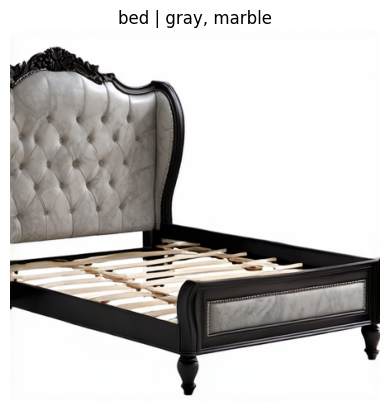

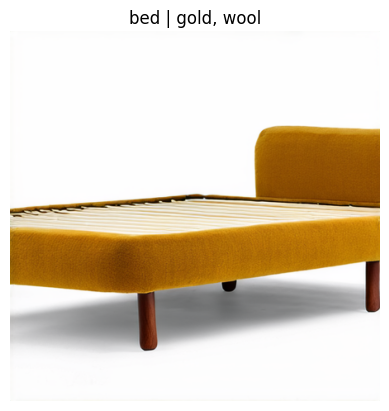

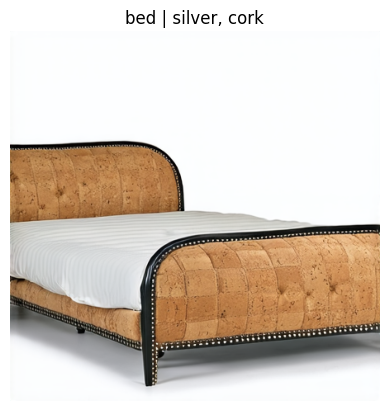

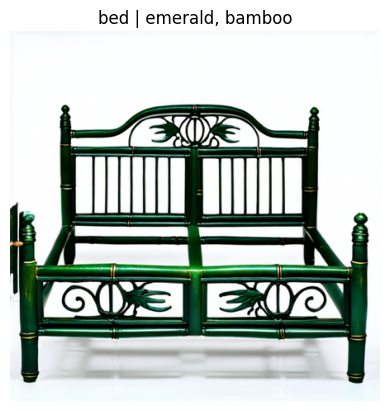

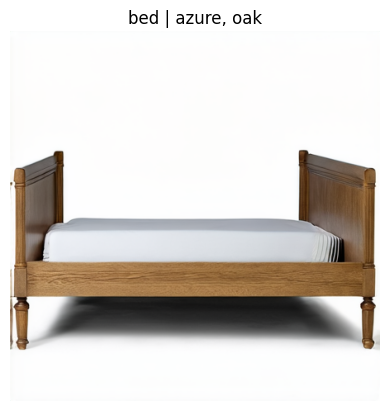

In [5]:
for i in range(5):
    img = df["image"][i]
    label = df["type"][i]
    clr = df["color"][i]
    mat = df["material"][i]
    plt.imshow(img)
    plt.title(f"{label} | {clr}, {mat}")
    plt.axis("off")
    plt.show()


In [6]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Image preprocessing for ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load pretrained ResNet50 model (remove final classification layer)
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # keep feature extractor
model.to(device)
model.eval()
print("✅ ResNet50 model loaded.")


Using device: cpu


c:\Users\nitik\OneDrive\Desktop\product-recommender\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nitik\OneDrive\Desktop\product-recommender\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ ResNet50 model loaded.


In [7]:
embeddings = []
labels = []

for i in tqdm(range(len(df))):
    try:
        img = df["image"][i].convert("RGB")
        x = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            emb = model(x).squeeze().cpu().numpy()
        embeddings.append(emb)
        labels.append(df["type"][i])
    except Exception as e:
        print(f"Error processing image {i}: {e}")
        embeddings.append(np.zeros(2048))
        labels.append("unknown")

embeddings = np.array(embeddings)
print("✅ Embeddings extracted successfully!")
print("Embeddings shape:", embeddings.shape)


  0%|          | 0/10000 [00:00<?, ?it/s]

✅ Embeddings extracted successfully!
Embeddings shape: (10000, 2048)


In [8]:
os.makedirs("../backend/data", exist_ok=True)
np.save("../backend/data/furniture_embeddings.npy", embeddings)
df.to_csv("../backend/data/furniture_metadata.csv", index=False)
print("✅ Saved embeddings and metadata CSV in backend/data/")


✅ Saved embeddings and metadata CSV in backend/data/


In [9]:
from sklearn.preprocessing import normalize

# Normalize embeddings (important for cosine similarity)
embeddings_norm = normalize(embeddings, norm="l2", axis=1)

# Fit NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=6, metric="cosine")
nbrs.fit(embeddings_norm)

print("✅ Nearest Neighbors model ready!")


✅ Nearest Neighbors model ready!


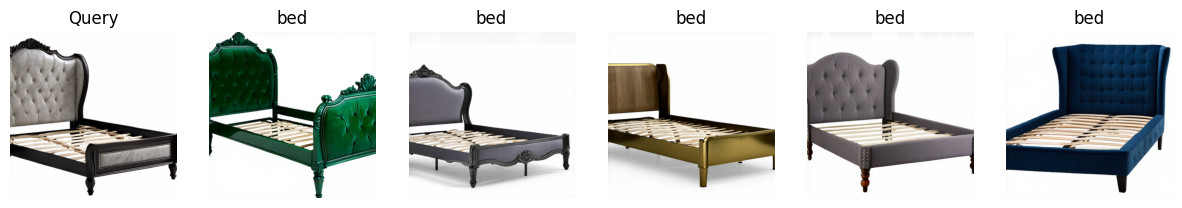

In [10]:
query_index = 0  # You can change this to try different images
distances, indices = nbrs.kneighbors([embeddings_norm[query_index]])

plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices[0]):
    plt.subplot(1, 6, i + 1)
    plt.imshow(df["image"][idx])
    title = "Query" if i == 0 else f"{df['type'][idx]}"
    plt.title(title)
    plt.axis("off")
plt.show()


In [11]:
from sklearn.metrics.pairwise import cosine_similarity

def recall_at_k(embeddings, df, k=5):
    recalls = []
    for i in range(len(df)):
        sims = cosine_similarity([embeddings[i]], embeddings)[0]
        top_k = np.argsort(sims)[-k-1:-1][::-1]
        correct = any(df["type"][i] == df["type"][j] for j in top_k)
        recalls.append(int(correct))
    return np.mean(recalls)

for k in [1, 3, 5]:
    r = recall_at_k(embeddings_norm, df, k)
    print(f"Recall@{k}: {r:.3f}")


Recall@1: 0.973
Recall@3: 0.991
Recall@5: 0.994
